# About: 既存マシンをAnsibleで操作可能にする

----

このNotebookでは、このNotebookが置かれたJupyter Notebook環境(コンテナ)から、既存マシンに対してAnsibleにより操作可能な状態にする手順を説明しています。

**Note** このNotebookは、NIIクラウド担当製Dockerイメージ https://hub.docker.com/r/niicloudoperation/notebook/ での利用を前提として記述しています。

# 前提条件

既存マシンに対する前提条件を確認します。

まず、以下の `target_host` 変数に、操作対象としたいマシンのIPアドレスもしくはドメイン名を指定しておきます。

このチュートリアルは、ここで指定されたホストに対して、実際にコマンドを発行することで、各説明について具体的に確認していきます。

In [1]:
target_host = 'XXX.XXX.207.86'
target_host

'XXX.XXX.207.86'

## 操作対象のマシンに対してJupyter Notebook環境から到達可能である

このNotebookからAnsibleを通じて操作対象のマシンを操作するためには、操作対象のマシンに、このNotebookが実行されているJupyter Notebook環境からネットワーク的に疎通可能である必要があります。



ここでは、`ping`コマンドを通じて確認してみます。

> Notebook (Python Kernelで実行している前提です) では、 `!` を行頭に記載することでshellコマンドを実行することができます。

In [2]:
!ping -c 4 {target_host}

PING XXX.XXX.207.86 (XXX.XXX.207.86): 56 data bytes
64 bytes from XXX.XXX.207.86: icmp_seq=0 ttl=37 time=5.612 ms
64 bytes from XXX.XXX.207.86: icmp_seq=1 ttl=37 time=6.052 ms
64 bytes from XXX.XXX.207.86: icmp_seq=2 ttl=37 time=10.599 ms
64 bytes from XXX.XXX.207.86: icmp_seq=3 ttl=37 time=7.651 ms
--- XXX.XXX.207.86 ping statistics ---
4 packets transmitted, 4 packets received, 0% packet loss
round-trip min/avg/max/stddev = 5.612/7.478/10.599/1.955 ms


上記セルが失敗せず、`Out [2]` タブで示されるような内容が出力されれば成功です。

なお、ここではping(**ICMP**)を使って疎通確認をしていますが、ファイアウォールの設定により疎通しない可能性があります。Ansibleの操作自体は原則として**SSH(TCP port 22)**を通じて実施されますので、ICMPが疎通しないことが明確な場合は上記セルはエラーのままスキップしても構いません。

## 操作対象のマシンに対してJupyter Notebook環境からSSHが許可されている

ネットワーク的に到達可能であることを確認したら、SSH(TCP port 22)が応答するかどうかを見てみましょう。

これには、`nc`(netcat)コマンドが便利です。

In [3]:
!nc -vz {target_host} 22

Connection to XXX.XXX.207.86 22 port [tcp/ssh] succeeded!


上記セルが失敗せず、`Out [3]` タブで示されるような内容が出力されれば成功です。

このメッセージが `Connection refused`であったり、`Connection timed out`であれば、ネットワークやファイアウォールの設定の問題の可能性があります。また、設定対象ホストによっては、SSHサーバをport 22で動作させていないかもしれません。このような場合には、上記テストコマンドの `22`の部分を変更して試してみてください。

## 操作対象のマシンにPythonインタプリタがインストールされている

Ansibleでは、操作対象のマシンにインストールされたPythonインタプリタを利用して様々な処理を実行します。



利用するPythonインタプリタの情報を設定します。

In [34]:
# Ubuntu 16.04の標準的なインストールの場合は /usr/bin/python3 、
# 他のOSでは /usr/bin/python だったりする・・・操作対象マシンの状況を確認してください
target_python_interpreter = '/usr/bin/python3'
target_python_interpreter

'/usr/bin/python3'

# SSH接続に関する設定

まず、どのようなSSH設定が必要か、整理していきましょう。このチュートリアルでは、以下のようなケースを想定します。

* SSHホストキーの確認
* SSHログイン時の認証方式
    * SSHログインをキーペアによって許可する環境
    * SSHログインをパスワードによって許可する環境
* SSH sudo (権限昇格)時のパスワードの有無

## SSHホストキーの確認

SSHする際に、Jupyter Notebookだと少し困るのが、Host keyの確認問い合わせ(yes/no)のような対話的なやり取りです。

**実際の運用では、なりすましでないことの確認をスキップするというわけにはいきません**ので、多少面倒ではありますがJupyter Notebookが持つTerminal機能であらかじめ実行しておくことにします。

まず、Jupyter Notebookの Terminal を開きます。ファイルツリーの [New] - [Terminal] からTerminal画面を開くことができます。

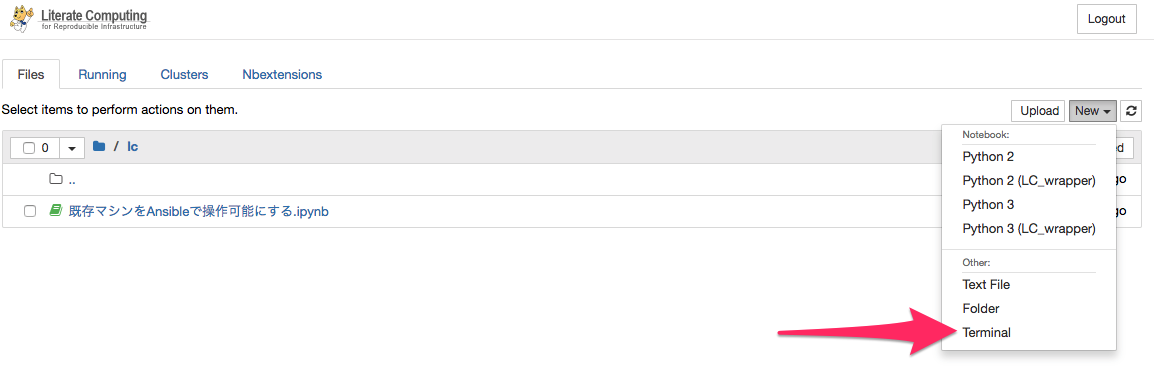

Terminal画面を開いたら、 `ssh {target_host}` ({target_host}は操作対象のIPアドレス・ドメイン名に読み替え) を実行します。あとは、通常のSSH接続と同様に、Host keyのFingerprintを確認し、`yes`を入力します。

これにより、`known_hosts`ファイルに受け入れを確認したHost keyの情報が保存され、次回ssh時からは問い合わせがされなくなります。

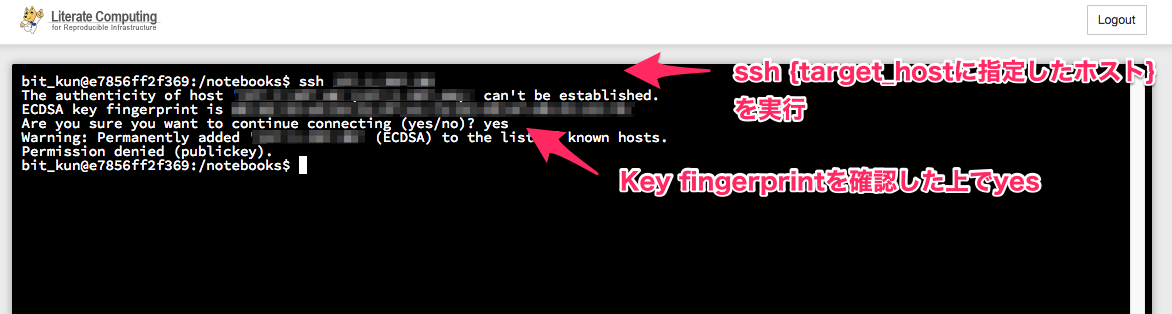

このようにしてsshのhost keyの受け入れをおこなったら、host keyが受け入れられたことを確認してみましょう。

以下のセルを実行してください。host keyが受け入れられている場合、`Out [6]`のような結果になるはずです。

> host keyが受け入れられていない場合は、 `Out [9]`のように`Are you sure you want to continue connecting (yes/no)?`と出力され実行完了しない(水色のまま)となります。
> 
> このような場合は、Jupyter Notebookのツールバーの停止( <i class="fa-stop fa"></i> )ボタンで中断し、上記のhost key受け入れ手順を再度実施してください。

In [10]:
!ssh {target_host} || exit 0

## SSHログイン時の認証方式

Host keyを確認して操作対象のマシンが正当な(想定した)マシンであることを確認したら、このマシンからログインできるよう、認証情報を設定します。

まず、ここから先の動作確認のため、SSHログインする際のユーザ名を変数として設定しておきます。

In [11]:
ssh_user = 'yazawa'
ssh_user

'yazawa'

また、ここから先は動作確認にAnsibleの実行を行います。しかしながら、*Ansibleの設定* 実施までは、一時ファイルに各設定ファイルを作成し、動作確認をしていきます。

In [12]:
import tempfile
import os
work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmpc1hqa30_'

### キーペアによる認証

Jupyter Notebook環境内に秘密鍵と公開鍵のペアを作成し、このうち公開鍵を操作対象サーバに設定することで、秘密鍵によるアクセスを可能にします。

秘密鍵のパスを設定します。公開鍵のパスは `{local_priv_key}.pub` になります。

> ここでファイルを作成している `/home/bit_kun/` は、コンテナの削除によりリセットされてしまうディレクトリです。永続化したい場合は、このパスに永続化した(Jupyter Notebook外部からは見えない)ディレクトリを指定するようにしてください。

In [15]:
local_priv_key = '/home/bit_kun/.ssh/lc_id_rsa'
local_priv_key

'/home/bit_kun/.ssh/lc_id_rsa'

キーペアが存在しない場合は、 `ssh-keygen` コマンドにより生成します。

In [21]:
if not os.path.exists(local_priv_key):
    # ssh-keygen のパラメータは運用する環境によって適宜変更すること
    !ssh-keygen -t rsa -b 4096 -C 'bit_kun@notebook' -P '' -f {local_priv_key}

Generating public/private rsa key pair.
Your identification has been saved in /home/bit_kun/.ssh/lc_id_rsa.
Your public key has been saved in /home/bit_kun/.ssh/lc_id_rsa.pub.
The key fingerprint is:
cb:88:c7:6f:04:9e:d4:83:6b:a1:6b:27:03:f9:2c:bd bit_kun@notebook
The key's randomart image is:
+---[RSA 4096]----+
|                 |
|                 |
|       o         |
|      = o        |
|   . + =S.       |
|  o .o=o..       |
|   =.o+.o        |
|  . O....        |
|   oE= ..        |
+-----------------+


公開鍵の内容は以下のセルのようになります。

In [22]:
!cat {local_priv_key}.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQCtgS+X04i2sU04m8wG+ul/Qyv9toVj9etI8DsQJBh7RAEj3AmES0d3T3cSigoQRY31MPVVnjDXaivJTWTDjFGO749bkt958VfdWUeKifxfzOuZifxA2rIPk4HxjqueynyHTchSTwGCCrIO8ylmzMzppkGR65AT1/xb6DkluTKi+gj7f4uLB53mNYpA1It5QOHZa9MWBZCUKrTw75XObCIAMRNWMcyBi1WA//qhHsVuVmlz/SujpbFYbyTl2p/I8VUdI2VnCZ/ldbqBOEOQg+/YKi9pzQPRXtM4ncli4cLpQ7RDbGFWb9nLN7CJS4ixtXN4x9G0tESDzSpeA4Wy88tfYIwQQwzi53a61rz7LJWn2Dbk3fMzFh2jL0UOQqV/StDCwvHiKQngmjpodO4Zbzl6wnYgontmvEoTl832NdaK+36pjw8N1HcXVwLP/oUFrgUXcl9dzia/Qr/fnWHLt7JlOevaUbEK4rtck9txURJfyPJ5b21nzXXCFsvE1yNsZpqIpqNhCjFF40Gvr+AD/GLhd+QBdcplwa4GMHcUYQPOUB42AdYJioAe2M01nQTGNG+4U6ZoYFiXlnWSg33rKh2FscQUGoFnljTaUKRkU+Tvm2sOrduk8qJ7SGoU2XRcq4lr1I6VjYDdTDsTqizs3rYTZtYZoeDTw8Khaum49OsoTw== bit_kun@notebook


上記の出力の内容を、操作対象ホストの `~/.ssh/authorized_keys` に追記します。一般的な環境であれば、{ssh_user}でログインした後、**以下のセル**に出力されたコマンドを実行すればOKです。

In [23]:
pub_key = None
with open(local_priv_key + '.pub', 'r') as f:
    pub_key = f.readlines()[0].strip()
print("echo '{}' >> ~/.ssh/authorized_keys".format(pub_key))

echo 'ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQCtgS+X04i2sU04m8wG+ul/Qyv9toVj9etI8DsQJBh7RAEj3AmES0d3T3cSigoQRY31MPVVnjDXaivJTWTDjFGO749bkt958VfdWUeKifxfzOuZifxA2rIPk4HxjqueynyHTchSTwGCCrIO8ylmzMzppkGR65AT1/xb6DkluTKi+gj7f4uLB53mNYpA1It5QOHZa9MWBZCUKrTw75XObCIAMRNWMcyBi1WA//qhHsVuVmlz/SujpbFYbyTl2p/I8VUdI2VnCZ/ldbqBOEOQg+/YKi9pzQPRXtM4ncli4cLpQ7RDbGFWb9nLN7CJS4ixtXN4x9G0tESDzSpeA4Wy88tfYIwQQwzi53a61rz7LJWn2Dbk3fMzFh2jL0UOQqV/StDCwvHiKQngmjpodO4Zbzl6wnYgontmvEoTl832NdaK+36pjw8N1HcXVwLP/oUFrgUXcl9dzia/Qr/fnWHLt7JlOevaUbEK4rtck9txURJfyPJ5b21nzXXCFsvE1yNsZpqIpqNhCjFF40Gvr+AD/GLhd+QBdcplwa4GMHcUYQPOUB42AdYJioAe2M01nQTGNG+4U6ZoYFiXlnWSg33rKh2FscQUGoFnljTaUKRkU+Tvm2sOrduk8qJ7SGoU2XRcq4lr1I6VjYDdTDsTqizs3rYTZtYZoeDTw8Khaum49OsoTw== bit_kun@notebook' >> ~/.ssh/authorized_keys


authorized_keysを登録したら、ansibleコマンドによりアクセスを試みます。

まず、一時ディレクトリの `hosts` ファイルに、Ansibleが必要とする情報を設定します。

In [63]:
with open(os.path.join(work_dir, 'hosts'), 'w') as f:
    f.write(('{host} ' +
             'ansible_ssh_user={user} ' +
             'ansible_python_interpreter={python_interpreter} ' +
             'ansible_ssh_private_key_file={priv_key}').format(host=target_host,
                                                               user=ssh_user,
                                                               priv_key=local_priv_key,
                                                               python_interpreter=target_python_interpreter))
!cat {work_dir}/hosts

XXX.XXX.207.86 ansible_ssh_user=yazawa ansible_python_interpreter=/usr/bin/python3 ansible_ssh_private_key_file=/home/bit_kun/.ssh/lc_id_rsa

Ansibleの `ping` モジュールを使って疎通確認をします。

`ping` モジュールは、AnsibleのInventory等で定義されたSSH接続情報を用いて、疎通確認、Pythonの動作確認を実施します。`Out [33]`のようにこのコマンドの実行が成功すれば、SSHログインのための認証情報設定は成功です。

> `Out [26]`のようになる場合は、先に示した操作対象のマシンの `.ssh/authorized_keys` への公開鍵設定がうまくいっていないか、`ssh_user`変数が正しく設定されていない可能性があります。
>
> `Out [30]`のようになる場合は、前提条件で示したPythonインタプリタが正しく設定されていない可能性があります。

In [33]:
!ansible -i {work_dir}/hosts -m ping all

XXX.XXX.207.86 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


SSHで接続できたことを確認したら、ユーザ `ssh_user` でログインしたかどうかを確認します。

以下のセルを実行し、出力結果がユーザ名 `ssh_user` と合致するかを確認してください。

In [66]:
!ansible -i {work_dir}/hosts -a whoami all

XXX.XXX.207.86 | SUCCESS | rc=0 >>
yazawa



### パスワードによる認証

SSHログインにはキーペアを用いることが一般的ですが、環境によってはパスワードでログインしなければならない場面もあるかもしれません。


> このセクションの例は、誤実行を防止するためFreeze状態(<i class="fa-freeze fa"></i>)にしてあります。
> 実行したい場合は、実行したいセル上でツールバーのUnfreezeボタン(<i class="fa-unfreeze fa"></i>)をクリックしてFreezeを解除した後実行してください。

#### パスワードを含むAnsible定義ファイルの作成

以下のセルを実行してください。パスワード入力を求める入力フィールドがセル上に現れますので、SSHログイン用のパスワードを入力してください。
この内容は変数に格納されます。

In [36]:
import getpass
ssh_login_password = getpass.getpass()

········


キーペアによる認証の例では、ホストに渡すログイン用のユーザ名やPythonインタプリタの情報をインベントリファイルに定義しました。

今回は、パスワードのような機微情報を含むため、インベントリには直接書かず、Ansible Vaultで暗号化を実施できるようホスト変数として定義することにします。ファイル構成は以下のようにします。

```
.
├── hosts
└── host_vars
    └── {target_host}
```

In [43]:
import yaml

with open(os.path.join(work_dir, 'hosts'), 'w') as f:
    f.write(target_host)

!mkdir -p {work_dir}/host_vars
with open(os.path.join(work_dir, 'host_vars', target_host), 'w') as f:
    f.write(yaml.dump(dict(ansible_ssh_user=ssh_user,
                           ansible_python_interpreter=target_python_interpreter,
                           ansible_ssh_pass=ssh_login_password)))
!cat {work_dir}/hosts
print('\n')
!ls -la {work_dir}/host_vars/{target_host}

XXX.XXX.207.86

-rw-r--r-- 1 bit_kun users 107 Jan  6 21:04 /tmp/tmpc1hqa30_/host_vars/XXX.XXX.207.86


#### Ansible Vaultによる暗号化

これでパスワードを含む設定ファイルを作成できました。しかしながら、このままでは `host_vars/{target_host}` は平文のため中身を覗かれてしまいます。そこで、`ansible-vault`コマンドを用いて暗号化します。

まず、Ansible Vaultで用いる適当なパスワードを決め、以下に入力します。この内容は、Jupyter Notebook環境の `~/.ansible_vault_pass` に書き込まれます。

In [50]:
vault_pass = getpass.getpass()

with open(os.path.expanduser('~/.ansible_vault_pass'), 'w') as f:
    f.write(vault_pass)

········


次に、このパスワードを使って `host_vars` 配下のファイルを暗号化します。

In [51]:
!ansible-vault encrypt {work_dir}/host_vars/{target_host} --vault-pass ~/.ansible_vault_pass

Encryption successful


暗号化後のファイルは、そのままでは内容がわからない状態になります。

In [52]:
!cat {work_dir}/host_vars/{target_host}

$ANSIBLE_VAULT;1.1;AES256
35356235653162636134633864663337343630373837326535306663643333663134303661663531
3739383435663633623431663838646130353163353162300a326365643666386535623334376138
38313165616133376262343664663334666439663463303761323464376132633435326464373761
3432306663626538330a636263373766353934306363653561636462616434336564353165343230
34393332343233353564653535333534623538643637616238666163653831356461383535643230
39656635326332666132316438646332303766383765656437643431313535313166386362323233
38323163343132316563626266656138303636316330323135663733383538663836626235663237
66633535633439363734653163323665393362303061356334656633636533303737616331306661
64373631393865346538356239353461303664333566336562366563386632306232


このようにして暗号化された`host_vars`を参照する場合、ansibleコマンドの実行時に、引数 `--vault-pass ~/.ansible_vault_pass` を指定する必要があります。

#### 疎通確認

Ansibleの `ping` モジュールを使って疎通確認をします。

`ping` モジュールは、AnsibleのInventory等で定義されたSSH接続情報を用いて、疎通確認、Pythonの動作確認を実施します。`Out [49]`のようにこのコマンドの実行が成功すれば、SSHログインのための認証情報設定は成功です。

> `Out [48]`のようになる場合は、先に示した `ssh_login_password` 変数へのパスワード入力がうまくいっていないか、`ssh_user`変数が正しく設定されていない可能性があります。


In [55]:
!ansible -i {work_dir}/hosts --vault-pass ~/.ansible_vault_pass -m ping all

XXX.XXX.207.86 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


SSHで接続できたことを確認したら、ユーザ `ssh_user` でログインしたかどうかを確認します。

以下のセルを実行し、出力結果がユーザ名 `ssh_user` と合致するかを確認してください。

In [72]:
!ansible -i {work_dir}/hosts --vault-pass ~/.ansible_vault_pass -a whoami all

XXX.XXX.207.86 | SUCCESS | rc=0 >>
yazawa



## SSH sudo時のパスワード指定の有無

Ansibleは特権ユーザになる必要がある場合に、sudoを使って昇格をしようとします。sudoにパスワードを求める環境においては、*パスワードによる認証*と同様に `host_vars` に接続情報を定義するようにします。

### パスワードを含むAnsible定義ファイルの作成

以下のセルを実行してください。パスワード入力を求める入力フィールドがセル上に現れますので、SSHログイン用のパスワードを入力してください。
この内容は変数に格納されます。

In [57]:
import getpass
ssh_become_password = getpass.getpass()

········


キーペアによる認証の例では、ホストに渡すログイン用のユーザ名やPythonインタプリタの情報をインベントリファイルに定義しました。

今回は、パスワードのような機微情報を含むため、インベントリには直接書かず、Ansible Vaultで暗号化を実施できるようホスト変数として定義することにします。ファイル構成は以下のようにします。

```
.
├── hosts
└── host_vars
    └── {target_host}
```

In [80]:
import yaml

with open(os.path.join(work_dir, 'hosts'), 'w') as f:
    f.write(target_host)

!mkdir -p {work_dir}/host_vars
settings = dict(ansible_ssh_user=ssh_user,
                ansible_python_interpreter=target_python_interpreter,
                ansible_become_pass=ssh_become_password)
if 'ssh_login_password' in globals():
    # SSHログイン時の認証方式 - パスワードによる認証の場合
    settings['ansible_ssh_pass'] = ssh_login_password
else:
    settings['ansible_ssh_private_key_file'] = local_priv_key
with open(os.path.join(work_dir, 'host_vars', target_host), 'w') as f:
    f.write(yaml.dump(settings))
!cat {work_dir}/hosts
print('\n')
!ls -la {work_dir}/host_vars/{target_host}

XXX.XXX.207.86

-rw------- 1 bit_kun users 172 Jan  6 21:40 /tmp/tmpc1hqa30_/host_vars/XXX.XXX.207.86


### Ansible Vaultによる暗号化

これでパスワードを含む設定ファイルを作成できました。しかしながら、このままでは `host_vars/{target_host}` は平文のため中身を覗かれてしまいます。そこで、`ansible-vault`コマンドを用いて暗号化します。

まず、Ansible Vaultで用いる適当なパスワードを決め、以下に入力します。この内容は、Jupyter Notebook環境の `~/.ansible_vault_pass` に書き込まれます。

In [81]:
if not os.path.exists(os.path.expanduser('~/.ansible_vault_pass')):
    # すでに~/.ansible_vault_passが定義済みであれば何もしない
    vault_pass = getpass.getpass()

    with open(os.path.expanduser('~/.ansible_vault_pass'), 'w') as f:
        f.write(vault_pass)

次に、このパスワードを使って `host_vars` 配下のファイルを暗号化します。

In [82]:
!ansible-vault encrypt {work_dir}/host_vars/{target_host} --vault-pass ~/.ansible_vault_pass

Encryption successful


暗号化後のファイルは、そのままでは内容がわからない状態になります。

In [83]:
!cat {work_dir}/host_vars/{target_host}

$ANSIBLE_VAULT;1.1;AES256
62633038343165613833643165383730346435656364353333633230653033643333633335303137
6665323237313138383162633139386638626638373663350a616235663430373264393539656538
30383636616165393935393632666634643261303232346633656538666331376130663030656233
6330386666373066660a636661393663343133373630613465666263663836303532373766373535
66653463616436363138353335336630373231363330356666643663313236633236396333333135
33303461376637616562666437653234353865343339313733393030653561316339353533623165
35666266303639376462653138633361323932393034653739323861323039666131383735326432
65363036323438336235333636343534643935633666613839653135356336326531613835373364
65306439303330636235303632323538643630306562316237303537333665303466613863383365
31313165663264396665323635633338633731353532353233313636306536643861356336306639
30356362623630376239343663373936313132623030313065636330336635393230323764306536
31663538656566656666633835306430613436303432306138363436653061636362396666356631
61

このようにして暗号化された`host_vars`を参照する場合、ansibleコマンドの実行時に、引数 `--vault-pass ~/.ansible_vault_pass` を指定する必要があります。

### becomeできることの確認

Ansibleコマンド実行時にbecomeオプションを付加し、昇格できることを確認します。

以下のセルを実行し、結果が `Out [84]`のように`root`となることを確認してください。

In [84]:
!ansible -i {work_dir}/hosts --become --vault-pass ~/.ansible_vault_pass -a whoami all

XXX.XXX.207.86 | SUCCESS | rc=0 >>
root



# Ansibleの設定

SSH接続に関する設定を確認することができたら、一時ファイルとして作成してあった設定ファイルを、常時利用できるように特定の場所にまとめ、簡単に使えるようにしましょう。

## 設定の整理

操作対象のマシンにアクセスするためのSSH接続設定は明らかになりましたが、これらの設定をどのようなファイルに配置・記述したらよいか？をいくつかポイントを解説します。

### グループの構成

ここまでで見てきた設定ファイルは、一時的なアクセスを想定したもので、単一のホストを前提としたものです。しかしながら、Ansibleで管理する対象は複数のホストである場合もあり、[About: Hadoop - Set! Inventory](http://nbviewer.jupyter.org/github/NII-cloud-operation/Literate-computing-Hadoop/blob/master/D10_Hadoop%20-%20Set%21%20Inventory.ipynb)の例にあるように、複数のホストに対して**グループ**を定義し、まとめてコマンドを発行するということがありえます。

ここでは、単純な例として、操作対象とした {target_host} を以下のグループ名を持つグループにまとめることにします。

In [85]:
target_group = 'test-machine'
target_group

'test-machine'

### 変数の定義対象

ここまで見てきた設定ファイルは、 `host_vars`によって、ホストごとに変数を定義していました。これは、ホストが複数になったときに非常に面倒になります。

そこで、同一グループに所属するホストの接続設定を共通のものにして、`group_vars`にまとめて定義するということが可能です。

**host_varsでの定義**

```
.
├── hosts
└── host_vars
    └── {target_host}
```

**group_varsでの定義**

```
.
├── hosts
└── group_vars
    └── {target_group}
```

## 設定ファイルの作成


### インベントリファイル

インベントリファイル(先の`hosts`)はAnsibleのあらゆるコマンドの実行時に与える必要があるファイルです。

このJupyter Notebookから単一のインベントリファイルを使用することがわかっている場合は、適当なディレクトリに `hosts`ファイルを作成し、これをデフォルトインベントリファイルとして設定することができます。

ここでは、Jupyter Notebookから編集しやすいように、Notebookのルートディレクトリ(`/notebooks`)への配置を考えてみます。

In [86]:
!touch /notebooks/hosts

この `/notebooks/hosts` ファイルは、リンク [hosts](/edit/hosts) をクリックすることでエディタを開くことができます。

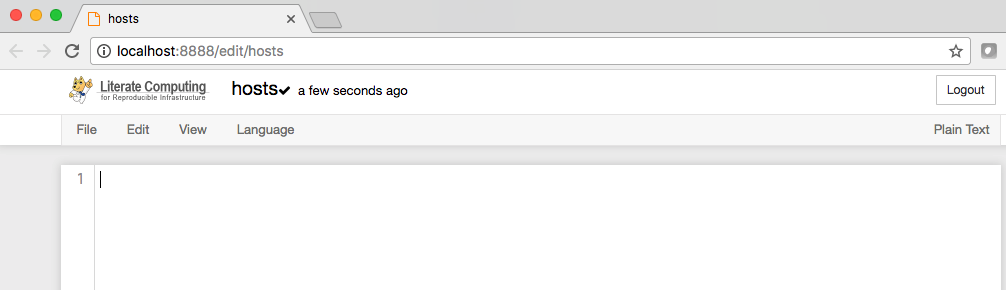

ここに、以下のセルの実行結果を記述してみてください。

In [87]:
print('[{g}]'.format(g=target_group))
!cat {work_dir}/hosts

[test-machine]
XXX.XXX.207.86

エディタに入力し、Saveをおこなったら、以下のセルを実行して、記述した内容が出力されることを確認します。

In [88]:
!cat /notebooks/hosts

[test-machine]
XXX.XXX.207.86

これをおこなったら、以下のようにAnsibleの`ping`モジュールを実行してみます。実行対象グループとして、 `target_group` を指定しています。ここでは、認証情報などを移行していないので、失敗するはずです。


In [91]:
!ansible -i /notebooks/hosts -m ping {target_group}

XXX.XXX.207.86 | UNREACHABLE! => {
    "changed": false, 
    "msg": "Failed to connect to the host via ssh: Permission denied (publickey).\r\n", 
    "unreachable": true
}


RuntimeError: Unexpected exit code: 4

では、次に、この`/notebooks/hosts`をデフォルトインベントリにしてみましょう。 `/etc/ansible/ansible.cfg`を利用します。

まず、現在の設定を確認します。

In [92]:
!cat /etc/ansible/ansible.cfg

[defaults]
forks = 3


このファイルに、 `inventory` を追記します。
今回は Ansible Vaultのパスワードファイルも明示してしまいましょう。

In [109]:
%%writefile {work_dir}/ansible.cfg
[defaults]
forks = 3
inventory = /notebooks/hosts
vault_password_file = ~/.ansible_vault_pass

Overwriting /tmp/tmpc1hqa30_/ansible.cfg


In [110]:
!sudo cp {work_dir}/ansible.cfg /etc/ansible/ansible.cfg

設定ファイルが更新されたことを確認します。

In [111]:
!cat /etc/ansible/ansible.cfg

[defaults]
forks = 3
inventory = /notebooks/hosts
vault_password_file = ~/.ansible_vault_pass

このようにすると、 `-i /notebooks/hosts`を指定しなくても、Ansibleのインベントリを利用できるようになります。
(まだ、認証情報などを移行していないので、失敗するはずです。)

In [100]:
!ansible -m ping {target_group}

XXX.XXX.207.86 | UNREACHABLE! => {
    "changed": false, 
    "msg": "Failed to connect to the host via ssh: Permission denied (publickey).\r\n", 
    "unreachable": true
}


RuntimeError: Unexpected exit code: 4

### 変数ファイル

先の接続確認では `host_vars`ファイルに接続設定を記述していましたが、ここでは、`{target_group}` に所属するすべてのホストが同じSSH接続設定を利用すると仮定して、ファイルを配置してみましょう。

`group_vars` ディレクトリは、インベントリファイルと同じディレクトリ配下に配置する必要があります。

In [101]:
!mkdir -p /notebooks/group_vars/

このディレクトリに、一時ディレクトリ内に作成した`host_vars/{target_host}`(暗号化されているもの)をコピーします。

In [103]:
!cp {work_dir}/host_vars/{target_host} /notebooks/group_vars/{target_group}

すると、以下のようなファイル配置になります。

In [107]:
!ls -la /notebooks/hosts
!echo
!echo /notebooks/group_vars
!ls -la /notebooks/group_vars

-rw-r--r-- 1 bit_kun users 27 Jan  6 22:09 /notebooks/hosts

/notebooks/group_vars
total 4
drwxr-xr-x  3 bit_kun users   96 Jan  6 22:22 .
drwxr-xr-x 97 bit_kun users 3104 Jan  6 22:21 ..
-rw-------  1 bit_kun users 1003 Jan  6 22:22 test-machine


これで、Ansibleで疎通できることを確認します。

In [112]:
!ansible -m ping {target_group}

XXX.XXX.207.86 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


# まとめ

Jupyter NotebookからAnsibleでマシンを操作可能にするまでの過程について、若干駆け足の部分がありつつも説明しました。実際には、細かなセキュリティ上の設定などあるとは思いますが、Jupyter Notebookとマシンのヒモ付にあたってのポイントは整理したつもりです。